In [47]:
import numpy as np
import pandas as pd
from os.path import join as oj
import os
import pandas as pd
import sys
import inspect
import datetime
from scipy.stats import percentileofscore
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.append(parentdir)
sys.path.append(parentdir + '/modeling')
import load_data
from fit_and_predict import add_preds
from functions import merge_data
from viz import  viz_interactive
import numpy as np
import pandas as pd
from os.path import join as oj
import os
import pandas as pd
import sys
import matplotlib as plt
from scipy.stats import percentileofscore

# CHANGE THIS
from exponential_modeling import *
from fit_and_predict import *

In [5]:
# Load in the Data

print('loading data...')
NUM_DAYS_LIST = [1, 2, 3, 4, 5, 6, 7]
df_county = load_data.load_county_level(data_dir=oj(parentdir, 'data'))

#df_county = add_preds(df_county, NUM_DAYS_LIST=NUM_DAYS_LIST,
#                          cached_dir=oj(parentdir, 'data'))

loading data...
loading county-level data...
loaded and merged COVID-19 cases/deaths data successfully


In [298]:
df_hos = pd.read_csv("../data/CA_hospitalizations.csv")
df_hos = df_hos[["County Name", "Most Recent Date", "COVID-19 Positive Patients"]]
df_hos = df_hos.rename(columns={"County Name": "CountyName", "Most Recent Date": "Date", 
                               "COVID-19 Positive Patients": "hospitalizations"})

In [299]:
# Merge the Data
fips = df_county[df_county["StateName"] == "CA"][["countyFIPS", "CountyName"]]
df_hos = df_hos.merge(fips, on="CountyName", how="left")
df_hos = df_hos.fillna(0)

In [300]:
df_CA = df_hos[["countyFIPS", "CountyName"]].drop_duplicates()

hospitz = []
for county in df_CA["CountyName"]:
    # Generate the Series
    arr = df_hos[df_hos["CountyName"] == county]["hospitalizations"].values
    hospitz.append(np.concatenate(([0], arr))) # Adding 0 since there seems to be an issue if we don't
#     hospitz.append(np.concatenate(([], arr))) # Adding 0 since there seems to be an issue if we don't

# Append
df_CA["hospitalizations"] = hospitz

In [282]:
preds = linear_fit(df_CA["hospitalizations"].values, mode="eval_mode")

In [331]:
# Exponential Fit
length = len(df_hos[df_hos["CountyName"] == "Los Angeles"]["hospitalizations"].values)
preds = []
k = 1
for i in range(k,length):
    hospitz = []
    for county in df_CA["CountyName"]:
        # Generate the Series
        arr = df_hos[df_hos["CountyName"] == county]["hospitalizations"].values[:i]
        hospitz.append(np.concatenate(([0], arr)))
        
#         hospitz.append(np.concatenate(([], arr)))

    # Append
    df_CA["hospitalizations"] = hospitz
    
    
    preds.append(exponential_fit(df_CA["hospitalizations"].values, mode="eval_mode", target_day=np.array([k])))
#     preds.append(linear_fit(df_CA["hospitalizations"].values, mode="eval_mode", target_day=np.array([1])))
    
preds= np.array(preds)[:, :, 0].T
preds = preds[:, 1:] # Drop the first 0s

In [328]:
#### Linear Fit
length = len(df_hos[df_hos["CountyName"] == "Los Angeles"]["hospitalizations"].values)
preds_linear = []
for i in range(4 + k,length):
    hospitz = []
    for county in df_CA["CountyName"]:
        # Generate the Series
        arr = df_hos[df_hos["CountyName"] == county]["hospitalizations"].values[:i]
        hospitz.append(np.concatenate(([0], arr))) 
        # Note: Concatenating 1 to avoid issue with 0's and linear fit

    # Append
    df_CA["hospitalizations"] = hospitz
    
    
#     preds.append(exponential_fit(df_CA["hospitalizations"].values, mode="eval_mode", target_day=np.array([1])))
    preds_linear.append(linear_fit(df_CA["hospitalizations"].values, mode="eval_mode", target_day=np.array([k])))
    
preds_linear= np.array(preds_linear)[:, :, 0].T
preds_linear = preds_linear[:, 1:] # Drop the first 0s

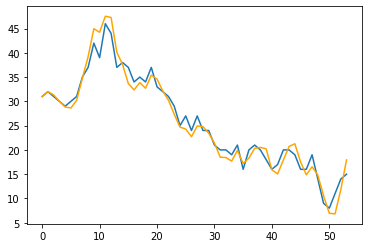

In [332]:
# Let's Plot LA Exponential
LA = df_CA["hospitalizations"][10][k:-1]
preds_LA = preds[10, :]
t = range(max(len(LA), len(preds_LA)))
plt.plot(t, LA)
plt.plot(t, preds_LA, color="orange")

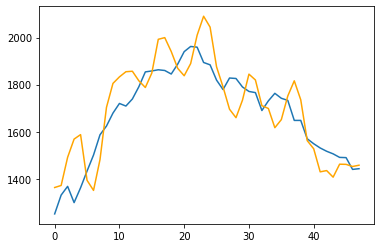

In [330]:
# Let's Plot LA Linear
LA = df_CA["hospitalizations"][0][4 + k:-1]
preds_LA = preds_linear[0, :]
t = range(len(LA))
t_lin = range(len(preds_LA))
plt.plot(t, LA)
plt.plot(t_lin, preds_LA, color="orange")

# Shared Model

In [337]:
# Does plugging in what we've done above just work?
# preds = fit_and_predict_shared_exponential(df_CA, outcome="hospitalizations", mode="eval_mode")

# Shared Exponential Fit
length = len(df_hos[df_hos["CountyName"] == "Los Angeles"]["hospitalizations"].values)
preds_shared = []
k = 3
# Start at 2 for 1 day prediction
for i in range(1 + k,length):
    hospitz = []
    for county in df_CA["CountyName"]:
        # Generate the Series
        arr = df_hos[df_hos["CountyName"] == county]["hospitalizations"].values[:i]
        hospitz.append(np.concatenate(([0], arr)))

    # Append
    df_CA["hospitalizations"] = hospitz
    
    # predict_future
    preds_shared.append(fit_and_predict_shared_exponential(df_CA, outcome="hospitalizations",
                                 mode="eval_mode", target_day=np.array([k])))
    
#     preds.append(linear_fit(df_CA["hospitalizations"].values, mode="eval_mode", target_day=np.array([1])))
    
preds_shared= np.array(preds_shared)[:, :, 0].T
preds_shared = preds_shared[:, 1:] # Drop the first 0s 

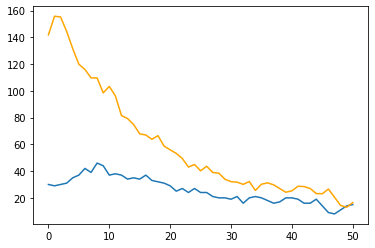

In [338]:
# Let's Plot LA Shared Exponential
LA = df_CA["hospitalizations"][10][1 + k:-1]
preds_LA = preds_shared[10, :] - 1
t = range(max(len(LA), len(preds_LA)))
plt.plot(t, LA)
plt.plot(t, preds_LA, color="orange")

In [268]:
# Just note how this works
tmp = create_shared_simple_dataset(df_CA, outcome="hospitalizations",days_to_subtract=1)
# fit_and_predict_shared_exponential(df_CA, outcome="hospitalizations",
#                                  mode="eval_mode", target_day=np.array([1]))

# Imputing Deaths with the MEPI

# Ensemble Model

In [ ]:
use_df = exponential_modeling.leave_t_day_out(df, target_day[-1])


weights = pmdl_weight.compute_pmdl_weight(use_df, 
                                          methods=methods, 
                                          outcome=outcome,
                                          target_day=target_day)
sum_weights = np.zeros(len(use_df))
for model_index in weights:
    sum_weights = sum_weights + np.array(weights[model_index])

#weighted_preds = np.zeros((len(use_df), len(target_day)))
weighted_preds = [np.zeros(len(target_day)) for i in range(len(use_df))]
for i in range(len(df)):
    for model_index in weights:
        weighted_preds[i] += np.array(predictions[model_index][i]) * weights[model_index][i] / sum_weights[i]
